In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import scipy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pd.set_option('display.float_format', lambda x: "%.5f" % x)

/kaggle/input/house-rent-prediction-dataset/Dataset Glossary.txt
/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv


In [2]:
# Helper Functions

# Rent summary calc
def rent_summary(col_name):
    return rent_data.groupby(col_name).agg({'Rent': ['mean', 'min','max', 'count']})

def run_ttest_avg_rent(col_name, col_value1, col_value2):
    return scipy.stats.ttest_ind(a=rent_data[rent_data[col_name] == col_value1].Rent, b= rent_data[rent_data[col_name] == col_value2].Rent)

In [3]:
f = open('/kaggle/input/house-rent-prediction-dataset/Dataset Glossary.txt', 'r')
print(f.read())

BHK: Number of Bedrooms, Hall, Kitchen.

Rent: Price of the Houses/Apartments/Flats.

Size: Size of the Houses/Apartments/Flats in Square Feet.

Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)

Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.

Area Locality: Locality of the Houses/Apartments/Flats.

City: City where the Houses/Apartments/Flats are Located.

Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.

Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.

Bathroom: Number of Bathrooms.

Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.


In [4]:
rent_data = pd.read_csv('/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv')

print(f"Shape of dataset is {rent_data.shape} \n")
print(rent_data.dtypes)
rent_data.head()

Shape of dataset is (4746, 12) 

Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [5]:
rent_data["Rent"].describe()


count      4746.00000
mean      34993.45133
std       78106.41294
min        1200.00000
25%       10000.00000
50%       16000.00000
75%       33000.00000
max     3500000.00000
Name: Rent, dtype: float64

In [6]:
# Data Conversions
rent_data["Posted On"] = pd.to_datetime(rent_data["Posted On"])
rent_data["Area Type"] = rent_data["Area Type"].astype('category')
rent_data["City"] = rent_data["City"].astype('category')
rent_data["Furnishing Status"] = rent_data["Furnishing Status"].astype('category')
rent_data["Tenant Preferred"] = rent_data["Tenant Preferred"].astype('category')
rent_data["Point of Contact"] = rent_data["Point of Contact"].astype('category')

# Add date part columns
rent_data["posted_on_month"] = rent_data["Posted On"].dt.month.astype('category')
rent_data["posted_on_weekday"] = rent_data["Posted On"].dt.weekday.astype('category')
rent_data["posted_on_dayofyear"] = rent_data["Posted On"].dt.dayofyear

rent_data["apartment_floor"] = rent_data["Floor"].str.extract(r'(.*?)out')
rent_data["apartment_floor"] = rent_data.apartment_floor.combine_first(rent_data.Floor)
rent_data["total_floors"] = rent_data["Floor"].str.extract(r'of (\d*)')
# assuming with no total floors, the given floor is the top floor
rent_data["total_floors"] = rent_data.total_floors.combine_first(rent_data.Floor)
# Replace Ground with 1
rent_data["apartment_floor"] = rent_data["apartment_floor"].str.replace("Ground|Upper Basement|Lower Basement", "1").astype("int")
rent_data["total_floors"] = rent_data["total_floors"].str.replace("Ground", "1").astype("int")
rent_data["pct_up_building"] = rent_data["apartment_floor"] / rent_data["total_floors"]

# Log transform response to lessen impact of outliers
rent_data["Rent_transform"] = np.log10(rent_data["Rent"])

# Drop unneeded columns
rent_data_modeling = rent_data.drop(['Posted On', 'Floor', 'posted_on_dayofyear', 'Rent', 'pct_up_building', 'Area Locality', 'posted_on_weekday'], axis=1)

# Manually running one-hot encoding due to issues with OneHotEncoder Pipeline preprocessor not allowing for non-numeric categories
rent_data_modeling_dummies = pd.get_dummies(rent_data_modeling)

rent_data.head()
print(rent_data_modeling.dtypes)
rent_data_modeling_dummies.isna().sum()

BHK                     int64
Size                    int64
Area Type            category
City                 category
Furnishing Status    category
Tenant Preferred     category
Bathroom                int64
Point of Contact     category
posted_on_month      category
apartment_floor         int64
total_floors            int64
Rent_transform        float64
dtype: object


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


BHK                                  0
Size                                 0
Bathroom                             0
apartment_floor                      0
total_floors                         0
Rent_transform                       0
Area Type_Built Area                 0
Area Type_Carpet Area                0
Area Type_Super Area                 0
City_Bangalore                       0
City_Chennai                         0
City_Delhi                           0
City_Hyderabad                       0
City_Kolkata                         0
City_Mumbai                          0
Furnishing Status_Furnished          0
Furnishing Status_Semi-Furnished     0
Furnishing Status_Unfurnished        0
Tenant Preferred_Bachelors           0
Tenant Preferred_Bachelors/Family    0
Tenant Preferred_Family              0
Point of Contact_Contact Agent       0
Point of Contact_Contact Builder     0
Point of Contact_Contact Owner       0
posted_on_month_4                    0
posted_on_month_5        

In [7]:
X = rent_data_modeling_dummies.drop(['Rent_transform'], axis = 1)
y = rent_data_modeling_dummies['Rent_transform']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size = 0.3, random_state = 1
)

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer


#numerical_columns_selector = selector(dtype_exclude="category")
#categorical_columns_selector = selector(dtype_include="category")

#numerical_columns = numerical_columns_selector(X)
#categorical_columns = categorical_columns_selector(X)

#categorical_preprocessor = OneHotEncoder()
#numerical_preprocessor = StandardScaler()

#preprocessor = ColumnTransformer([
    #('one-hot-encoder', categorical_preprocessor, categorical_columns),
    #('standard_scaler', numerical_preprocessor, numerical_columns)])

pipe = make_pipeline(StandardScaler(), RandomForestRegressor())

my_model = pipe.fit(X_train, y_train)

y_pred = my_model.predict(X_test)

from sklearn import metrics
#import library
# constructor
# .fit(X_train, y_train)
# .predict(X_test)
# run RMSE or another scoring metric


In [8]:
list(zip(X.columns, pipe[1].feature_importances_))

[('BHK', 0.023527172471503027),
 ('Size', 0.13931656520837774),
 ('Bathroom', 0.22726007636672438),
 ('apartment_floor', 0.019521534925057878),
 ('total_floors', 0.0726999360258565),
 ('Area Type_Built Area', 6.461600821286537e-06),
 ('Area Type_Carpet Area', 0.0042095668795272),
 ('Area Type_Super Area', 0.004247602017010532),
 ('City_Bangalore', 0.004147923699844043),
 ('City_Chennai', 0.003209044155293355),
 ('City_Delhi', 0.01031585463261333),
 ('City_Hyderabad', 0.004145741081507199),
 ('City_Kolkata', 0.006758053980216414),
 ('City_Mumbai', 0.07537021249228254),
 ('Furnishing Status_Furnished', 0.008811991494137009),
 ('Furnishing Status_Semi-Furnished', 0.0042560686876532885),
 ('Furnishing Status_Unfurnished', 0.00861376377007038),
 ('Tenant Preferred_Bachelors', 0.00450494197084885),
 ('Tenant Preferred_Bachelors/Family', 0.004037488679539095),
 ('Tenant Preferred_Family', 0.004617367327091925),
 ('Point of Contact_Contact Agent', 0.3377436795685083),
 ('Point of Contact_Conta

In [9]:
metrics.mean_absolute_error(y_true = 10**y_test, y_pred = 10**y_pred)

13675.66060707591

In [10]:
test_v_pred = pd.DataFrame({'Actuals': 10**y_test, 'Predicted': 10**y_pred})
test_v_pred['Diff'] = test_v_pred['Actuals'] - test_v_pred['Predicted']
test_v_pred['Diff_Squared'] = (test_v_pred['Diff'])**2
(test_v_pred['Diff_Squared'].mean()/test_v_pred.shape[0])**0.5


2534.0972006646116

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Rent_transform'>

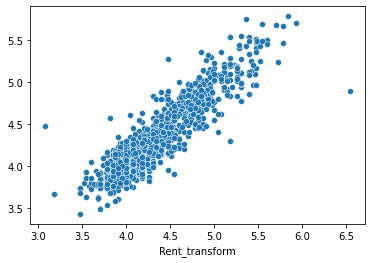

In [11]:
sns.scatterplot(y_test, my_model.predict(X_test))

In [12]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [13]:
rent_data["Rent"].describe()

print(rent_data["Rent"].std())
print(rent_data["Rent"].mean() + rent_data["Rent"].std() * 3)
rent_data[rent_data["Rent"] > rent_data["Rent"].mean() + rent_data["Rent"].std() * 5]

78106.4129373483
269312.69013947854


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,posted_on_month,posted_on_weekday,posted_on_dayofyear,apartment_floor,total_floors,pct_up_building,Rent_transform
726,2022-06-20,4,600000,2500,12 out of 13,Carpet Area,"Mount Marry, Bandra West",Mumbai,Semi-Furnished,Bachelors/Family,4,Contact Agent,6,0,171,12,13,0.92308,5.77815
792,2022-06-13,5,600000,3200,10 out of 16,Carpet Area,Bandra East,Mumbai,Semi-Furnished,Bachelors/Family,5,Contact Agent,6,0,164,10,16,0.62500,5.77815
827,2022-05-18,4,1000000,3064,18 out of 45,Carpet Area,"Raheja Artesia, Worli",Mumbai,Semi-Furnished,Family,4,Contact Agent,5,2,138,18,45,0.40000,6.00000
839,2022-05-19,5,450000,3400,2 out of 5,Carpet Area,Bandra West,Mumbai,Semi-Furnished,Bachelors/Family,5,Contact Agent,5,3,139,2,5,0.40000,5.65321
1001,2022-06-01,4,1200000,5000,4 out of 15,Carpet Area,Juhu,Mumbai,Semi-Furnished,Bachelors/Family,4,Contact Agent,6,2,152,4,15,0.26667,6.07918
1023,2022-07-09,5,500000,3900,4 out of 6,Carpet Area,Altamount Road,Mumbai,Furnished,Bachelors/Family,5,Contact Agent,7,5,190,4,6,0.66667,5.69897
1319,2022-05-31,5,650000,3000,8 out of 10,Carpet Area,Khar West,Mumbai,Semi-Furnished,Bachelors/Family,5,Contact Agent,5,1,151,8,10,0.80000,5.81291
1329,2022-06-23,4,850000,3200,2 out of 4,Carpet Area,Breach Candy,Mumbai,Furnished,Bachelors/Family,4,Contact Agent,6,3,174,2,4,0.50000,5.92942
1384,2022-05-27,5,600000,4500,7 out of 20,Carpet Area,Bandra West,Mumbai,Furnished,Bachelors,5,Contact Agent,5,4,147,7,20,0.35000,5.77815
1459,2022-06-27,4,700000,3200,24 out of 24,Carpet Area,"Lady Ratan Tower, Worli",Mumbai,Furnished,Bachelors/Family,4,Contact Agent,6,0,178,24,24,1.00000,5.84510


<AxesSubplot:xlabel='Rent_transform'>

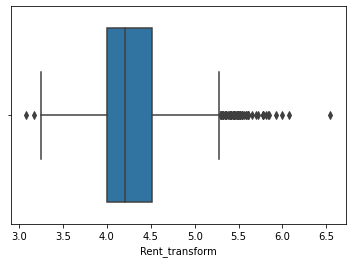

In [14]:
sns.boxplot(data=rent_data, x="Rent_transform")

<AxesSubplot:xlabel='posted_on_month', ylabel='Rent_transform'>

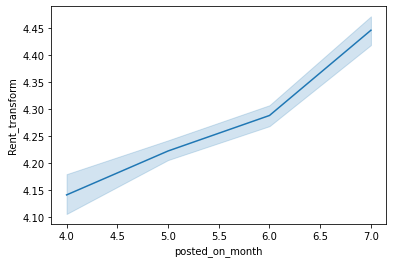

In [15]:

sns.lineplot(x="posted_on_month", y="Rent_transform", data = rent_data)

<AxesSubplot:xlabel='pct_up_building', ylabel='Rent'>

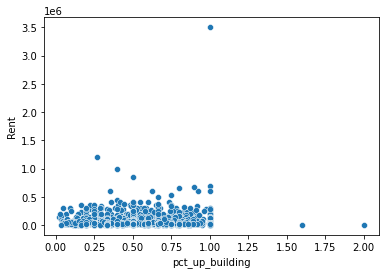

In [16]:
sns.scatterplot(x="pct_up_building", y="Rent", data = rent_data, ci=None)

<AxesSubplot:xlabel='Size', ylabel='Rent_transform'>

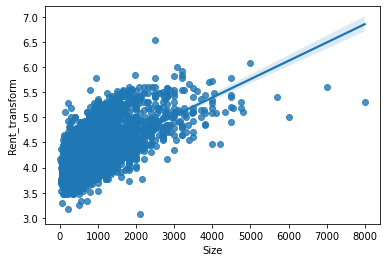

In [17]:
sns.regplot(x="Size", y="Rent_transform", data = rent_data)

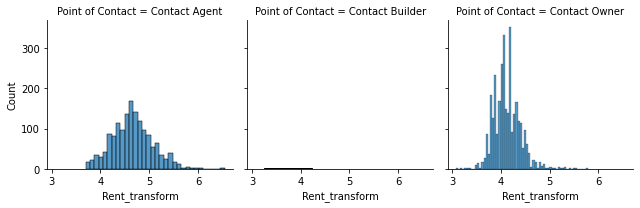

In [18]:
g = sns.FacetGrid(rent_data, col="Point of Contact")
g.map(sns.histplot, "Rent_transform")

In [19]:
#TODO:
# 3) Figure out whether Point of Contact is interesting or not
# 5) 

In [20]:
rent_summary("BHK")


Rent                      
            mean    min      max count
BHK                                   
1    14139.22365   1500   200000  1167
2    22113.86402   2000   600000  2265
3    55863.06284   1200  3500000  1098
4   168864.55556  10000  1200000   189
5   297500.00000  22500   650000    19
6    73125.00000  20000   280000     8

In [21]:
run_ttest_avg_rent("BHK", 2, 1)

Ttest_indResult(statistic=9.881933271480133, pvalue=1.00017760303535e-22)

In [22]:
rent_summary("Area Type")

Rent                     
                   mean   min      max count
Area Type                                   
Built Area  10500.00000  6000    15000     2
Carpet Area 52385.89730  1200  3500000  2298
Super Area  18673.39657  1500   350000  2446

In [23]:
run_ttest_avg_rent("Area Type", "Carpet Area", "Super Area")

Ttest_indResult(statistic=15.210786596096431, pvalue=4.7262804171882595e-51)

In [24]:
rent_summary("City")

Rent                     
                 mean   min      max count
City                                      
Bangalore 24966.36569  3500  3500000   886
Chennai   21614.09203  3000   600000   891
Delhi     29461.98347  2000   530000   605
Hyderabad 20555.04839  1200   400000   868
Kolkata   11645.17366  1500   180000   524
Mumbai    85321.20473  4500  1200000   972

In [25]:
rent_summary("Furnishing Status")

Rent                     
                         mean   min      max count
Furnishing Status                                 
Furnished         56110.30588  1200   850000   680
Semi-Furnished    38718.81075  1500  3500000  2251
Unfurnished       22461.63581  2000   600000  1815

In [26]:
run_ttest_avg_rent("Furnishing Status", "Semi-Furnished", "Unfurnished")

Ttest_indResult(statistic=6.718043406720098, pvalue=2.0971925772574332e-11)

In [27]:
rent_summary("Tenant Preferred")

Rent                     
                        mean   min      max count
Tenant Preferred                                 
Bachelors        42143.79398  3500  3500000   830
Bachelors/Family 31210.79268  1200  1200000  3444
Family           50020.34110  5000  1000000   472

In [28]:
run_ttest_avg_rent("Tenant Preferred", "Bachelors", "Family")

Ttest_indResult(statistic=-1.1865922936048936, pvalue=0.23560527823306707)

In [29]:
rent_summary("Bathroom")

Rent                       
                 mean     min      max count
Bathroom                                    
1         11862.16214    1500   100000  1474
2         25043.53819    3200   600000  2291
3         63176.69826    1200  3500000   749
4        167846.15385   15000  1200000   156
5        252350.00000   27000   680000    60
6        177500.00000   20000   400000    12
7         81666.66667   35000   150000     3
10       200000.00000  200000   200000     1

In [30]:
rent_summary("Point of Contact")

Rent                     
                        mean   min      max count
Point of Contact                                 
Contact Agent    73481.15893  5000  3500000  1529
Contact Builder   5500.00000  5500     5500     1
Contact Owner    16704.20647  1200   600000  3216

In [31]:
run_ttest_avg_rent("Point of Contact", "Contact Agent", "Contact Owner")

Ttest_indResult(statistic=24.875536189185514, pvalue=1.7116933486655452e-128)

<AxesSubplot:xlabel='Posted On', ylabel='Rent'>

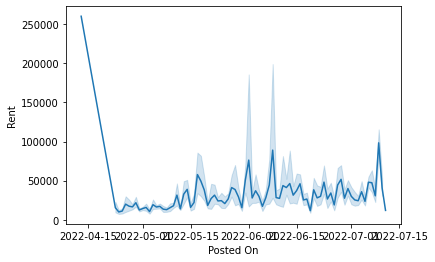

In [32]:
import seaborn as sns

sns.lineplot(x = "Posted On", y = "Rent", data = rent_data)

In [33]:
rent_data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,posted_on_month,posted_on_weekday,posted_on_dayofyear,apartment_floor,total_floors,pct_up_building,Rent_transform
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,5,2,138,1,2,0.50000,4.00000
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,5,4,133,1,3,0.33333,4.30103
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,5,0,136,1,3,0.33333,4.23045
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,7,0,185,1,2,0.50000,4.00000
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,5,0,129,1,2,0.50000,3.87506
